In [1]:
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [7]:
path = "C:/Users/OPTIMUSPRIME/Desktop/Studia/Magisterka/Faints-Prediction/"
BP_filename = "BP.csv"
HR_filename = "HR.csv"

train_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/training_set.txt", header=None).values.tolist()]
test_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/test_set.txt", header=None).values.tolist()]
validation_indices =  [str(indx[0]) for indx in pd.read_csv(path + "DATA/validation_set.txt", header=None).values.tolist()]
all_indices = train_indices + test_indices + validation_indices

In [8]:
BP_data = pd.read_csv(path + "DATA/" + BP_filename, low_memory=False)[all_indices]
HR_data = pd.read_csv(path + "DATA/" + HR_filename, low_memory=False)[all_indices]
labels = {col: BP_data[col].iloc[0] for col in BP_data}

BP_max_value = BP_data.iloc[1:].astype(np.float32).max().max()
BP_min_value = BP_data.iloc[1:].astype(np.float32).min().min()
HR_max_value = HR_data.iloc[1:].astype(np.float32).max().max()
HR_min_value = HR_data.iloc[1:].astype(np.float32).min().min()

BP_scaler = MinMaxScaler().fit(np.array([BP_min_value, BP_max_value]).reshape(-1,1))
HR_scaler = MinMaxScaler().fit(np.array([HR_min_value, HR_max_value]).reshape(-1,1))

BP_data_scaled = BP_data.iloc[1:].astype(np.float32).copy()
BP_data_scaled[all_indices] = BP_scaler.transform(BP_data_scaled[all_indices])

HR_data_scaled = HR_data.iloc[1:].astype(np.float32).copy()
HR_data_scaled[all_indices] = HR_scaler.transform(HR_data_scaled[all_indices])

BP_data_orig = BP_data.iloc[1:].astype(np.float32).copy()
HR_data_orig = HR_data.iloc[1:].astype(np.float32).copy()

In [9]:
# SMOOTHING
BP_data_orig_averaged = BP_data_orig.rolling(60).mean()
HR_data_orig_averaged = HR_data_orig.rolling(60).mean()

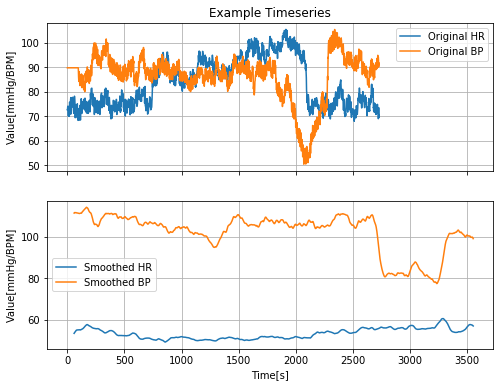

In [59]:
#PLOT EXAMPLE TIMESERIES
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(8,6))

ax1.plot(HR_data_orig['606'], label='Original HR')
ax1.plot(BP_data_orig['606'], label='Original BP')
ax1.set(ylabel = 'Value[mmHg/BPM]')
ax1.grid()
ax1.legend(loc='best')
ax1.set_title("Example Timeseries")

ax2.plot(HR_data_orig_averaged['675'], label='Smoothed HR')
ax2.plot(BP_data_orig_averaged['675'], label='Smoothed BP')
ax2.set(xlabel = 'Time[s]', ylabel = 'Value[mmHg/BPM]')
ax2.grid()
ax2.legend(loc='best')

fig.savefig("Example Timeseries2.png")

In [10]:
indexes = ['1', '92', '110', '158', '286', '295', '375', '393', '460', '501', '606', '658', '675']
# indexes = ['375', '393']

In [11]:
def label_func(index, start, end, color):
    for i in range(start, end):
        BP_HR_validation_labels[index][i] = color

BP_HR_validation_labels = dict()
BP_validation = dict()
HR_validation = dict()
for index in indexes:
    BPx = np.array(BP_data_orig_averaged[index])
    HRx = np.array(HR_data_orig_averaged[index])
    BPx = BPx[~np.isnan(BPx)]
    HRx = HRx[~np.isnan(HRx)]
    BPx = BPx[:-(BPx.shape[0] % 32)]
    HRx = HRx[:-(HRx.shape[0] % 32)]
    BPxs = np.array(np.array_split(BPx, int(len(BPx)/32)))
    HRxs = np.array(np.array_split(HRx, int(len(HRx)/32)))
    BP_HR_validation_labels[index] = np.array(['g']*len(BPxs))
    BP_validation[index] = BPxs
    HR_validation[index]= HRxs

In [82]:
def plot_timeseries(index, j):
#     plt.figure(figsize = (12,6))
    ax = axes[floor(j/3)][j%3]
    plt.ylim((30,160))
    ax.grid()
    if j > 8:
        ax.set(xlabel = 'Time[s]')
    if j % 3 == 0:
        ax.set(ylabel = 'Value[mmHg/BPM]')
    if j == 1:
        ax.set_title("Manually Labeled Timeseries")
    t = 0
    for BP_interval, HR_interval, label in zip(BP_validation[index], HR_validation[index], BP_HR_validation_labels[index]):
        if t == 0:
            time_range = range(t, t + len(BP_interval)) 
            ax.plot(time_range, BP_interval, color=label, linestyle='-')
            ax.plot(time_range, HR_interval, color=label, linestyle='-')
            t += len(BP_interval)
        else:
            time_range = range(t - 1, t + len(BP_interval)) 
            BP_interval = np.concatenate(([BP_last_elem], BP_interval))
            HR_interval = np.concatenate(([HR_last_elem], HR_interval))
            ax.plot(time_range, BP_interval, color=label, linestyle='-')
            ax.plot(time_range, HR_interval, color=label, linestyle='-')
            t += len(BP_interval) - 1
        BP_last_elem = BP_interval[-1]
        HR_last_elem = HR_interval[-1]

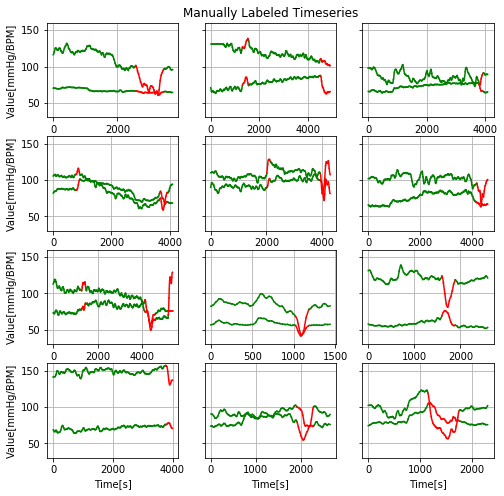

In [88]:
fig, axes = plt.subplots(4, 3, sharey=True, figsize=(8,8))
# fig.suptitle("Manually Labeled Timeseries")
for i, j in zip(indexes[:-1], range(len(indexes))):
    plot_timeseries(i, j)
fig.savefig("ValidationTimeseries.png")

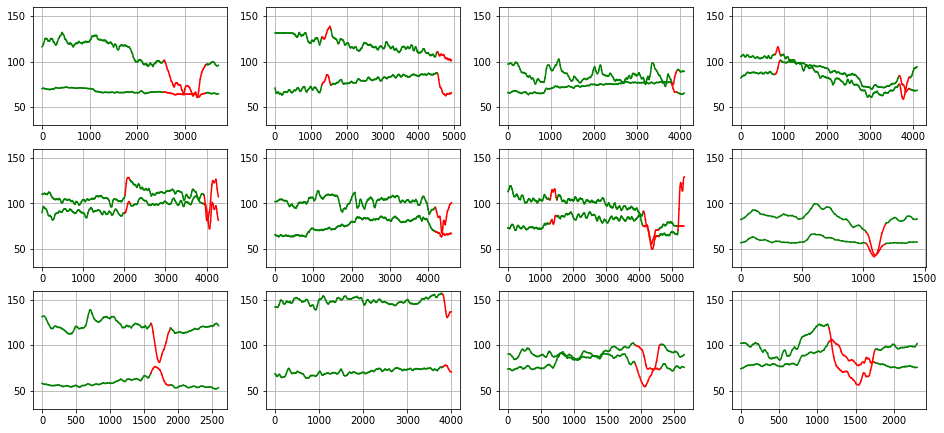

In [76]:
plt.figure(figsize=(16,10))
for i, j in zip(indexes[:-1], range(len(indexes))):
    plt.subplot(4,4,j+1)
    plot_timeseries(i)

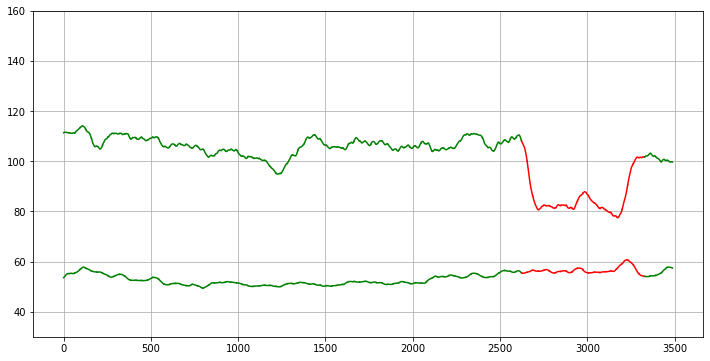

In [25]:
#675
index = "675"
label_func(index, 82, 104, 'r')
plot_timeseries(index)

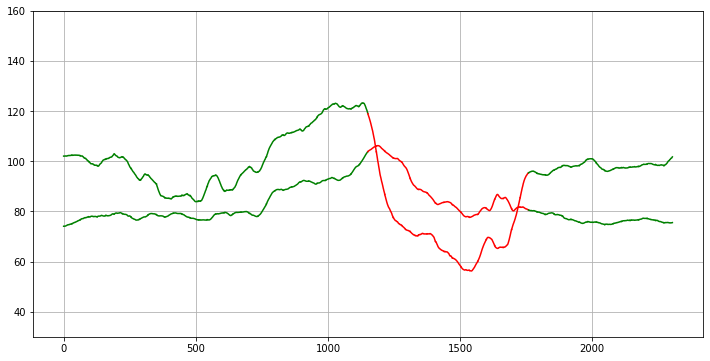

In [26]:
#658
index= "658"
label_func(index, 36, 55, 'r')
plot_timeseries(index)

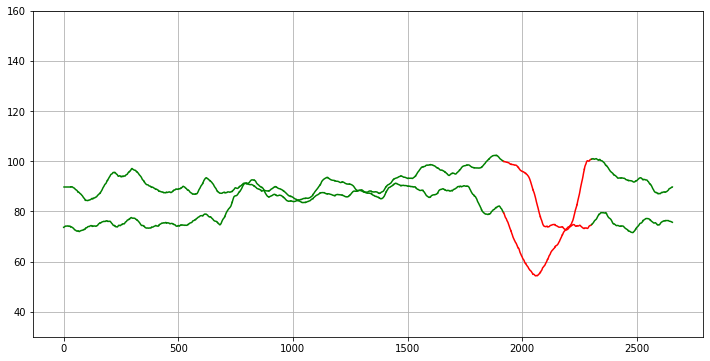

In [27]:
#606
index = "606"
label_func(index, 60, 72, 'r')
plot_timeseries(index)

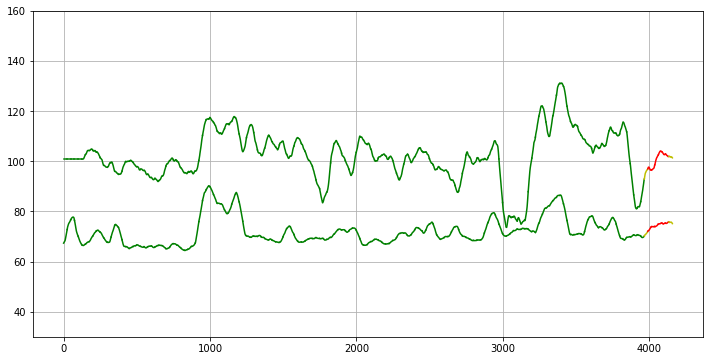

In [278]:
#559 ???
index = "559"
label_func(index, 160, 161, 'y')
label_func(index, 161, 167, 'r')
label_func(index, 167, 168, 'y')
plot_timeseries(index)

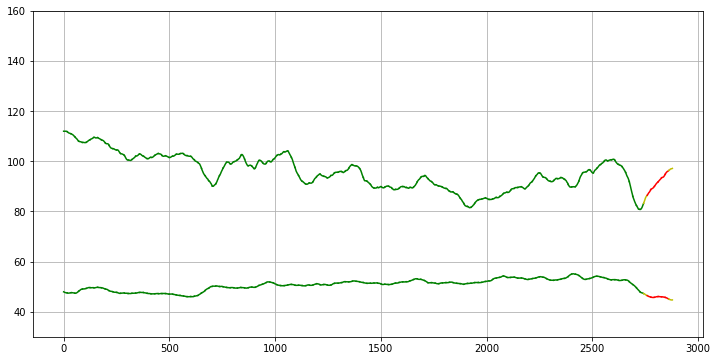

In [276]:
#538 ???
index = "538"
label_func(index, 160, 161, 'y')
label_func(index, 161, 167, 'r')
label_func(index, 167, 168, 'y')
plot_timeseries(index)

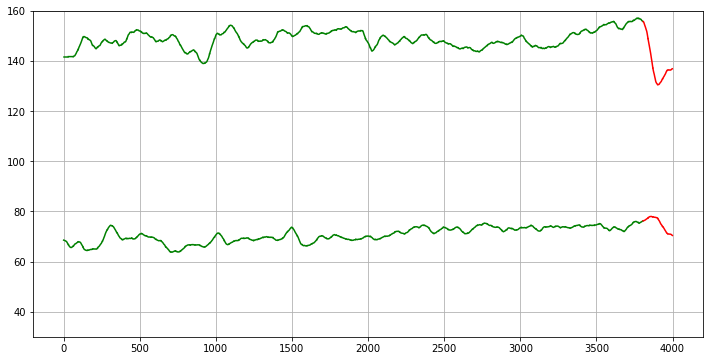

In [28]:
#501
index = "501"
label_func(index, 119, 125, 'r')
plot_timeseries(index)

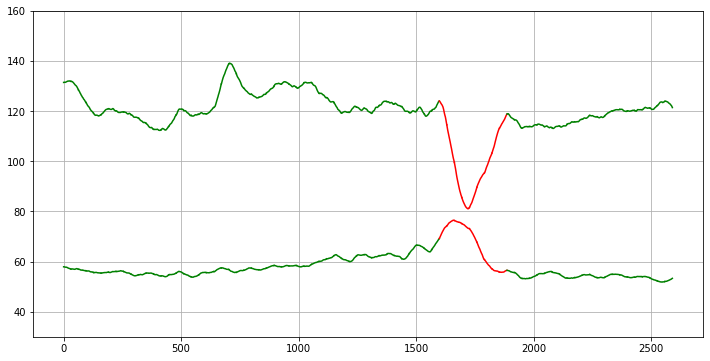

In [29]:
#460
index = "460"
label_func(index, 50, 59, 'r')
plot_timeseries(index)

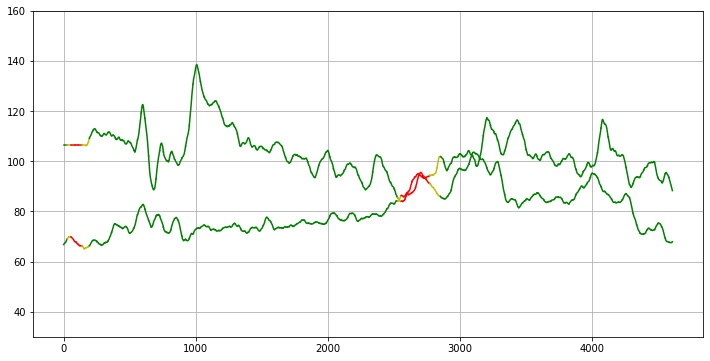

In [257]:
#419 ???
index = "419"
label_func(1, 2, 'y')
label_func(2, 5, 'r')
label_func(5, 7, 'y')

label_func(91, 92, 'y')
label_func(92, 100, 'r')
label_func(100, 103, 'y')
plot_timeseries(index)

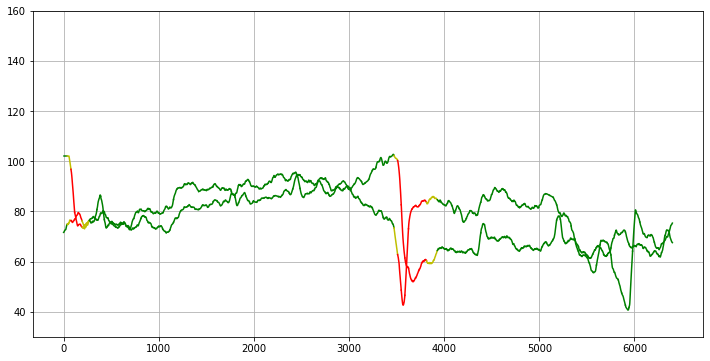

In [255]:
#409 ???
label_func(1, 2, 'y')
label_func(2, 5, 'r')
label_func(5, 7, 'y')

label_func(91, 92, 'y')
label_func(92, 100, 'r')
label_func(100, 103, 'y')
plot_timeseries(index)

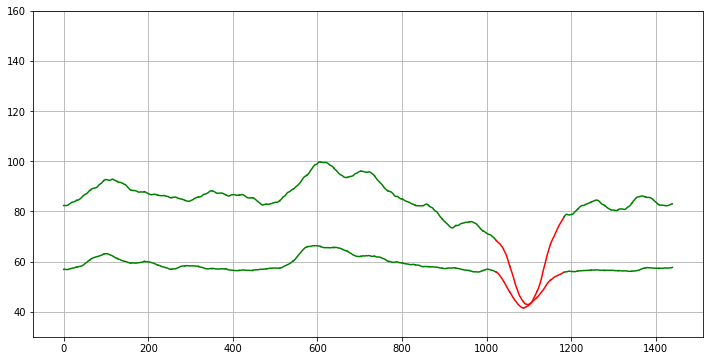

In [32]:
#393
index = "393"
label_func(index, 32, 37, 'r')
plot_timeseries(index)

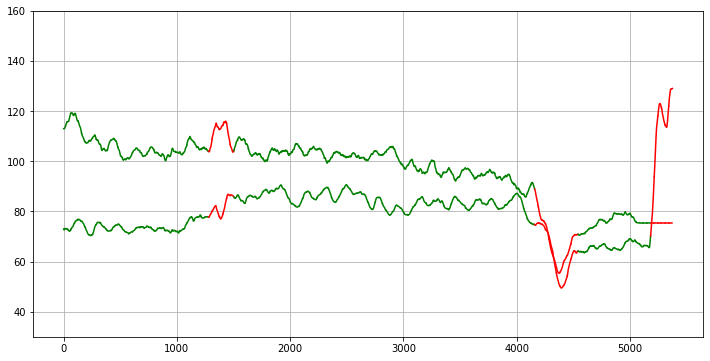

In [64]:
#375
index = "375"
label_func(index, 130, 142, 'r')
label_func(index, 162, 168, 'r')
plot_timeseries(index)

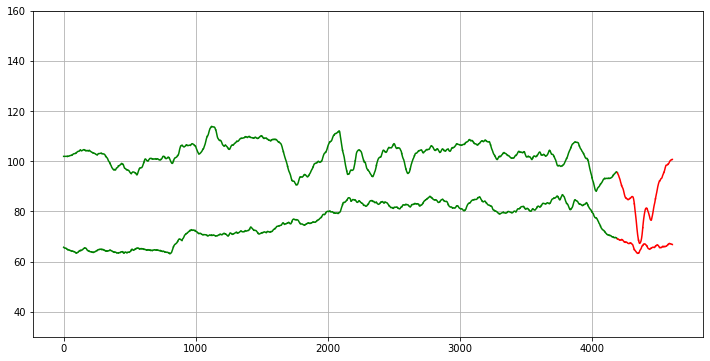

In [34]:
#295
index = "295"
label_func(index, 131, 144, 'r')
plot_timeseries(index)

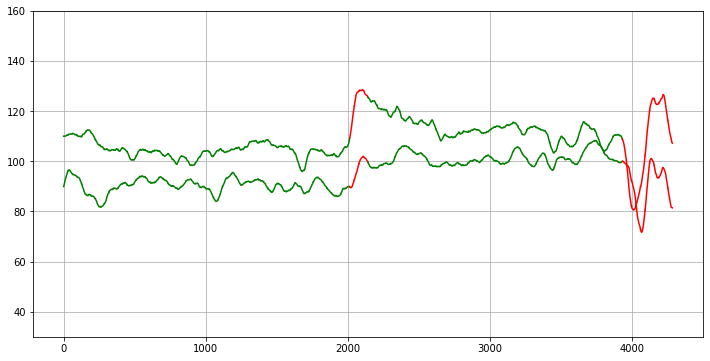

In [37]:
#286
index = "286"
label_func(index, 63, 67, 'r')
label_func(index, 123, 134, 'r')
plot_timeseries(index)

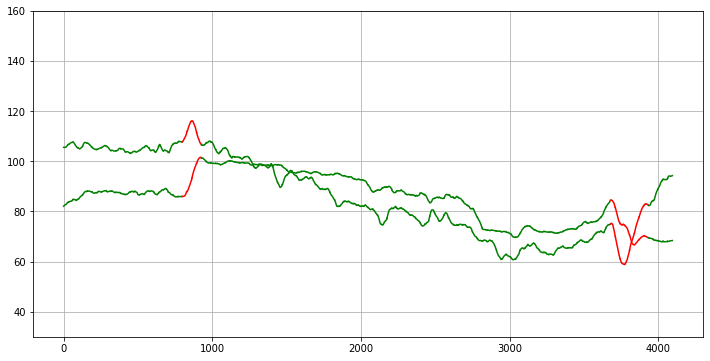

In [44]:
#158
index = "158"
label_func(index, 25, 29, 'r')
label_func(index, 115, 123, 'r')
plot_timeseries(index)

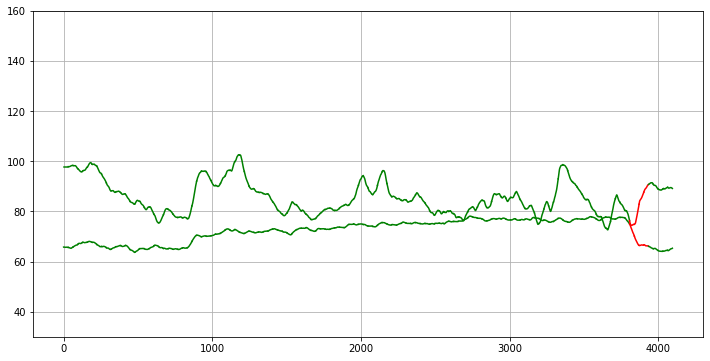

In [47]:
#110
index = "110"
label_func(index, 119, 123, 'r')
plot_timeseries(index)

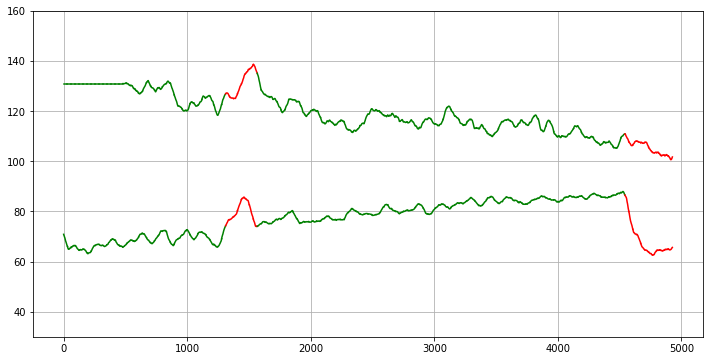

In [53]:
#92
index = "92"
label_func(index, 41, 49, 'r')
label_func(index, 142, 154, 'r')
plot_timeseries(index)

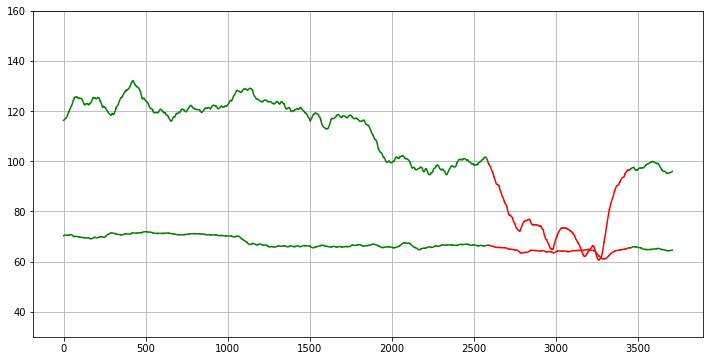

In [59]:
#1
index = "1"
label_func(index, 81, 108, 'r')
plot_timeseries(index)

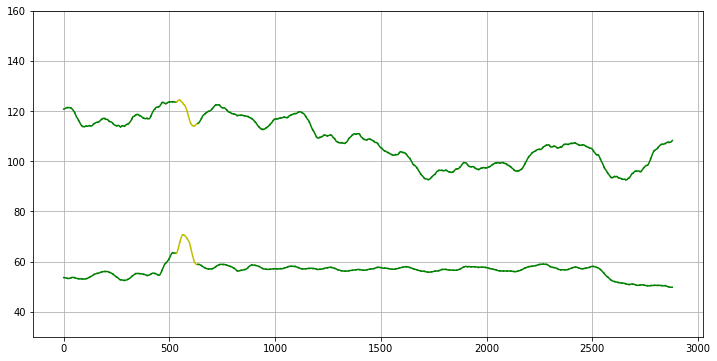

In [134]:
#320 ???
label_func(30, 36, 'y')

plt.figure(figsize = (12,6))
plt.ylim((30,160))
plt.grid()
t = 0
for BP_interval, HR_interval, label in zip(BP_validation[index], HR_validation[index], BP_HR_validation_labels[index]):
    if t == 0:
        time_range = range(t, t + len(BP_interval)) 
        plt.plot(time_range, BP_interval, color=label, linestyle='-')
        plt.plot(time_range, HR_interval, color=label, linestyle='-')
        t += len(BP_interval)
    else:
        time_range = range(t - 1, t + len(BP_interval)) 
        BP_interval = np.concatenate(([BP_last_elem], BP_interval))
        HR_interval = np.concatenate(([HR_last_elem], HR_interval))
        plt.plot(time_range, BP_interval, color=label, linestyle='-')
        plt.plot(time_range, HR_interval, color=label, linestyle='-')
        t += len(BP_interval) - 1
    BP_last_elem = BP_interval[-1]
    HR_last_elem = HR_interval[-1]

In [76]:
index = '1'
label_func('1', 80, 81, 'r')
label_func('1', 81, 107, 'r')
label_func('1', 107, 108, 'r')
index = '92' 
label_func('92', 41, 49, 'r')
label_func('92', 142, 143, 'r')
label_func('92', 143, 154, 'r')
index = '110' 
label_func('110', 119, 120, 'r')
label_func('110', 120, 123, 'r')
index = '158' 
label_func('158', 25, 29, 'r')
label_func('158', 115, 116, 'r')
label_func('158', 116, 122, 'r')
label_func('158', 122, 123, 'r')
index = '286' 
label_func('286', 63, 65, 'r')
label_func('286', 65, 67, 'r')
label_func('286', 123, 124, 'r')
label_func('286', 124, 129, 'r')
label_func('286', 129, 131, 'r')
label_func('286', 131, 134, 'r')
index = '295' 
label_func('295', 131, 134, 'r')
label_func('295', 134, 144, 'r')
index = '375'
label_func('375', 40, 47, 'r')
label_func('375', 129, 133, 'r')
label_func('375', 133, 141, 'r')
label_func('375', 141, 144, 'r')
label_func('375', 162, 168, 'r')
index = '393' 
label_func('393', 32, 36, 'r')
label_func('393', 36, 37, 'r')
index = '460' 
label_func('460', 50, 58, 'r')
label_func('460', 58, 59, 'r')
index = '501'
label_func('501', 119, 120, 'r')
label_func('501', 120, 124, 'r')
label_func('501', 124, 125, 'r')
index = '606'
label_func('606', 60, 61, 'r')
label_func('606', 61, 70, 'r')
label_func('606', 70, 72, 'r')
index = '658', 
label_func('658', 36, 53, 'r')
label_func('658', 53, 55, 'r')
index ='675', 
label_func('675', 82, 101, 'r')
label_func('675', 101, 104, 'r')

In [ ]:
def label_func(index, start, end, color):
    for i in range(start, end):
        BP_HR_validation_labels[index][i] = color

index = '1'
label_func('1', 80, 81, 'y')
label_func('1', 81, 107, 'r')
label_func('1', 107, 111, 'y')
index = '375'
label_func('375', 40, 47, 'y')
label_func('375', 129, 133, 'y')
label_func('375', 133, 141, 'r')
label_func('375', 141, 144, 'y')
label_func('375', 162, 168, 'r')
index = '92' 
label_func('92', 41, 49, 'y')
label_func('92', 140, 143, 'y')
label_func('92', 143, 154, 'r')
index = '110' 
label_func('110', 119, 120, 'y')
label_func('110', 120, 123, 'r')
label_func('110', 123, 125, 'y')
index = '158' 
label_func('158', 24, 28, 'y')
label_func('158', 115, 116, 'y')
label_func('158', 116, 122, 'r')
label_func('158', 122, 123, 'y')
index = '286' 
label_func('286', 61, 62, 'y')
label_func('286', 62, 65, 'r')
label_func('286', 65, 67, 'y')
label_func('286', 123, 124, 'y')
label_func('286', 124, 129, 'r')
label_func('286', 129, 131, 'y')
label_func('286', 131, 134, 'r')
index = '295' 
label_func('295', 131, 134, 'y')
label_func('295', 134, 144, 'r')
index = '393' 
label_func('393', 31, 32, 'y')
label_func('393', 32, 36, 'r')
label_func('393', 36, 37, 'y')
index = '460' 
label_func('460', 49, 50, 'y')
label_func('460', 50, 58, 'r')
label_func('460', 58, 59, 'y')
index = '501'
label_func('501', 119, 120, 'y')
label_func('501', 120, 124, 'r')
label_func('501', 124, 125, 'y')
index = '606'
label_func('606', 59, 61, 'y')
label_func('606', 61, 70, 'r')
label_func('606', 70, 72, 'y')
index = '658', 
label_func('658', 35, 36, 'y')
label_func('658', 36, 53, 'r')
label_func('658', 53, 55, 'y')
index ='675', 
label_func('675', 80, 82, 'y')
label_func('675', 82, 101, 'r')
label_func('675', 101, 104, 'y')